# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="anferico/bert-for-patents" #"microsoft/deberta-v3-small" #"anferico/bert-for-patents"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.9.1
Found existing installation: transformers 4.16.2
Uninstalling transformers-4.16.2:
  Successfully uninstalled transformers-4.16.2


Found existing installation: tokenizers 0.11.6
Uninstalling tokenizers-0.11.6:
  Successfully uninstalled tokenizers-0.11.6


Looking in links: ../input/pppm-pip-wheels
Processing /kaggle/input/pppm-pip-wheels/transformers-4.18.0-py3-none-any.whl
Processing /kaggle/input/pppm-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.1 requires transformers<4.17,>=4.1, but you have transformers 4.18.0 which is incompatible.


Looking in links: ../input/pppm-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] #+ '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] #+ '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network


# EDA

<AxesSubplot:>

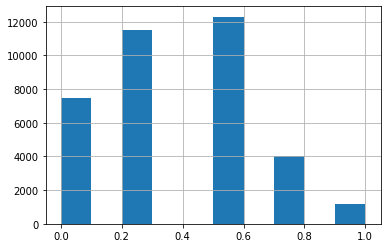

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target']) + 3 + 3
#                 + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 60


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [16]:
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)


{'input_ids': tensor([    2, 35736,     3, 35736,  1662, 10461,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
tensor(0.5000)


# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [20]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 1s (remain 47m 3s) Loss: 0.7587(0.7587) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 43s (remain 11m 37s) Loss: 0.6720(0.6628) Grad: 113597.6641  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 26s (remain 10m 45s) Loss: 0.6720(0.6408) Grad: 111407.9766  LR: 0.00001998  
Epoch: [1][300/1709] Elapsed 2m 8s (remain 9m 59s) Loss: 0.6199(0.6249) Grad: 146739.5156  LR: 0.00001996  
Epoch: [1][400/1709] Elapsed 2m 50s (remain 9m 15s) Loss: 0.6213(0.6142) Grad: 163034.7031  LR: 0.00001992  
Epoch: [1][500/1709] Elapsed 3m 32s (remain 8m 32s) Loss: 0.6247(0.6063) Grad: 143194.1562  LR: 0.00001988  
Epoch: [1][600/1709] Elapsed 4m 14s (remain 7m 49s) Loss: 0.4041(0.5987) Grad: 106071.7188  LR: 0.00001983  
Epoch: [1][700/1709] Elapsed 4m 56s (remain 7m 6s) Loss: 0.6063(0.5942) Grad: 100318.4062  LR: 0.00001977  
Epoch: [1][800/1709] Elapsed 5m 38s (remain 6m 23s) Loss: 0.5589(0.5894) Grad: 156251.4688  LR: 0.00001970  
Epoch: [1][900/1709] Elapsed 6

Epoch 1 - avg_train_loss: 0.5746  avg_val_loss: 0.5509  time: 779s
Epoch 1 - Score: 0.8202
Epoch 1 - Save Best Score: 0.8202 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.5109(0.5509) 
Epoch: [2][0/1709] Elapsed 0m 0s (remain 23m 17s) Loss: 0.6244(0.6244) Grad: 166188.5156  LR: 0.00001866  
Epoch: [2][100/1709] Elapsed 0m 42s (remain 11m 19s) Loss: 0.5647(0.5335) Grad: 184128.6719  LR: 0.00001850  
Epoch: [2][200/1709] Elapsed 1m 24s (remain 10m 33s) Loss: 0.5958(0.5347) Grad: 305677.9375  LR: 0.00001834  
Epoch: [2][300/1709] Elapsed 2m 6s (remain 9m 49s) Loss: 0.5049(0.5315) Grad: 175323.2344  LR: 0.00001816  
Epoch: [2][400/1709] Elapsed 2m 47s (remain 9m 7s) Loss: 0.5529(0.5316) Grad: 52264.7812  LR: 0.00001798  
Epoch: [2][500/1709] Elapsed 3m 29s (remain 8m 25s) Loss: 0.3834(0.5319) Grad: 122630.8984  LR: 0.00001780  
Epoch: [2][600/1709] Elapsed 4m 11s (remain 7m 42s) Loss: 0.3968(0.5312) Grad: 60987.0859  LR: 0.00001760  
Epoch: [2][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5748(0.5312) Grad: 92694.1172  LR: 0.00001740  
Epoch: [2][800/1709] Elapsed 5m 34s (remain 6m 19s) Loss: 0.4460(0.

Epoch 2 - avg_train_loss: 0.5278  avg_val_loss: 0.5467  time: 774s
Epoch 2 - Score: 0.8320
Epoch 2 - Save Best Score: 0.8320 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.4959(0.5467) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 18m 17s) Loss: 0.4797(0.4797) Grad: 85980.1406  LR: 0.00001500  
Epoch: [3][100/1709] Elapsed 0m 42s (remain 11m 14s) Loss: 0.5646(0.5122) Grad: 151112.6719  LR: 0.00001473  
Epoch: [3][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.4939(0.5123) Grad: 112119.2734  LR: 0.00001446  
Epoch: [3][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.5467(0.5139) Grad: 53800.1367  LR: 0.00001418  
Epoch: [3][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.6054(0.5149) Grad: 70254.4844  LR: 0.00001390  
Epoch: [3][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.5154(0.5131) Grad: 65851.9766  LR: 0.00001362  
Epoch: [3][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.5993(0.5121) Grad: 102580.2188  LR: 0.00001333  
Epoch: [3][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5397(0.5097) Grad: 93915.1484  LR: 0.00001304  
Epoch: [3][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.5173(0.50

Epoch 3 - avg_train_loss: 0.5095  avg_val_loss: 0.5486  time: 774s
Epoch 3 - Score: 0.8470
Epoch 3 - Save Best Score: 0.8470 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.4922(0.5486) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 18m 14s) Loss: 0.5017(0.5017) Grad: 90584.3906  LR: 0.00001000  
Epoch: [4][100/1709] Elapsed 0m 42s (remain 11m 15s) Loss: 0.4213(0.5038) Grad: 325444.5312  LR: 0.00000970  
Epoch: [4][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.5225(0.5059) Grad: 53326.7383  LR: 0.00000939  
Epoch: [4][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.5623(0.5026) Grad: 40436.5312  LR: 0.00000908  
Epoch: [4][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.5831(0.5014) Grad: 50749.3945  LR: 0.00000878  
Epoch: [4][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.4374(0.5003) Grad: 92106.4844  LR: 0.00000848  
Epoch: [4][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.4005(0.5014) Grad: 41977.6016  LR: 0.00000817  
Epoch: [4][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4408(0.5014) Grad: 34137.1875  LR: 0.00000787  
Epoch: [4][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.4794(0.5013

Epoch 4 - avg_train_loss: 0.4997  avg_val_loss: 0.5514  time: 774s
Epoch 4 - Score: 0.8481
Epoch 4 - Save Best Score: 0.8481 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.5125(0.5514) 
Epoch: [5][0/1709] Elapsed 0m 0s (remain 18m 8s) Loss: 0.5079(0.5079) Grad: 55949.2305  LR: 0.00000500  
Epoch: [5][100/1709] Elapsed 0m 42s (remain 11m 13s) Loss: 0.4866(0.4924) Grad: 69200.8047  LR: 0.00000474  
Epoch: [5][200/1709] Elapsed 1m 23s (remain 10m 29s) Loss: 0.5556(0.4981) Grad: 47441.8672  LR: 0.00000448  
Epoch: [5][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.5481(0.5016) Grad: 38334.0586  LR: 0.00000423  
Epoch: [5][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.5365(0.5001) Grad: 41723.5273  LR: 0.00000398  
Epoch: [5][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.4418(0.4962) Grad: 33791.5000  LR: 0.00000374  
Epoch: [5][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.4622(0.4955) Grad: 50348.0117  LR: 0.00000350  
Epoch: [5][700/1709] Elapsed 4m 52s (remain 6m 59s) Loss: 0.5334(0.4960) Grad: 37684.8164  LR: 0.00000327  
Epoch: [5][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.4385(0.4953)

Epoch 5 - avg_train_loss: 0.4939  avg_val_loss: 0.5578  time: 773s
Epoch 5 - Score: 0.8487
Epoch 5 - Save Best Score: 0.8487 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.5121(0.5578) 
Epoch: [6][0/1709] Elapsed 0m 0s (remain 18m 54s) Loss: 0.5486(0.5486) Grad: 47265.6094  LR: 0.00000134  
Epoch: [6][100/1709] Elapsed 0m 42s (remain 11m 14s) Loss: 0.5440(0.4884) Grad: 49288.6758  LR: 0.00000119  
Epoch: [6][200/1709] Elapsed 1m 23s (remain 10m 29s) Loss: 0.4612(0.4926) Grad: 35721.3828  LR: 0.00000105  
Epoch: [6][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.3523(0.4942) Grad: 67277.0938  LR: 0.00000092  
Epoch: [6][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.3956(0.4899) Grad: 22261.3359  LR: 0.00000080  
Epoch: [6][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.3903(0.4891) Grad: 66745.8828  LR: 0.00000068  
Epoch: [6][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.5676(0.4899) Grad: 70179.1641  LR: 0.00000057  
Epoch: [6][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4946(0.4895) Grad: 30306.1602  LR: 0.00000048  
Epoch: [6][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.5007(0.4891)

Epoch 6 - avg_train_loss: 0.4906  avg_val_loss: 0.5576  time: 773s
Epoch 6 - Score: 0.8486


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.5090(0.5576) 


========== fold: 0 result ==========
Score: 0.8487
========== fold: 1 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 0s (remain 16m 55s) Loss: 0.8361(0.8361) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 42s (remain 11m 11s) Loss: 0.5954(0.6567) Grad: 66789.2344  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 23s (remain 10m 28s) Loss: 0.5744(0.6282) Grad: 58133.5742  LR: 0.00001998  
Epoch: [1][300/1709] Elapsed 2m 5s (remain 9m 46s) Loss: 0.5989(0.6132) Grad: 51433.4727  LR: 0.00001996  
Epoch: [1][400/1709] Elapsed 2m 47s (remain 9m 4s) Loss: 0.4097(0.6047) Grad: 39034.0781  LR: 0.00001992  
Epoch: [1][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.5356(0.5986) Grad: 26558.6562  LR: 0.00001988  
Epoch: [1][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.5878(0.5940) Grad: 57345.6523  LR: 0.00001983  
Epoch: [1][700/1709] Elapsed 4m 51s (remain 6m 59s) Loss: 0.6073(0.5910) Grad: 28287.8828  LR: 0.00001977  
Epoch: [1][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.4757(0.5878) Grad: 25396.8926  LR: 0.00001970  
Epoch: [1][900/1709] Elapsed 6m 15s (

Epoch 1 - avg_train_loss: 0.5712  avg_val_loss: 0.5664  time: 774s
Epoch 1 - Score: 0.8157
Epoch 1 - Save Best Score: 0.8157 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3951(0.5664) 
Epoch: [2][0/1709] Elapsed 0m 1s (remain 30m 39s) Loss: 0.5669(0.5669) Grad: 98820.7031  LR: 0.00001866  
Epoch: [2][100/1709] Elapsed 0m 42s (remain 11m 20s) Loss: 0.6171(0.5262) Grad: 69336.1328  LR: 0.00001850  
Epoch: [2][200/1709] Elapsed 1m 24s (remain 10m 33s) Loss: 0.4144(0.5320) Grad: 39163.6328  LR: 0.00001834  
Epoch: [2][300/1709] Elapsed 2m 6s (remain 9m 49s) Loss: 0.5588(0.5265) Grad: 53864.1484  LR: 0.00001816  
Epoch: [2][400/1709] Elapsed 2m 47s (remain 9m 7s) Loss: 0.4251(0.5267) Grad: 44774.3594  LR: 0.00001798  
Epoch: [2][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.5585(0.5263) Grad: 57923.4766  LR: 0.00001780  
Epoch: [2][600/1709] Elapsed 4m 11s (remain 7m 42s) Loss: 0.5203(0.5264) Grad: 37675.6289  LR: 0.00001760  
Epoch: [2][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5159(0.5251) Grad: 76263.2500  LR: 0.00001740  
Epoch: [2][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.6090(0.5244)

Epoch 2 - avg_train_loss: 0.5243  avg_val_loss: 0.5550  time: 774s
Epoch 2 - Score: 0.8370
Epoch 2 - Save Best Score: 0.8370 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.4786(0.5550) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 20m 43s) Loss: 0.5934(0.5934) Grad: 65158.2578  LR: 0.00001500  
Epoch: [3][100/1709] Elapsed 0m 42s (remain 11m 14s) Loss: 0.5878(0.5070) Grad: 29439.3984  LR: 0.00001473  
Epoch: [3][200/1709] Elapsed 1m 23s (remain 10m 29s) Loss: 0.4127(0.5086) Grad: 47190.0312  LR: 0.00001446  
Epoch: [3][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.4483(0.5062) Grad: 45402.8945  LR: 0.00001419  
Epoch: [3][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.6453(0.5080) Grad: 55214.6836  LR: 0.00001391  
Epoch: [3][500/1709] Elapsed 3m 29s (remain 8m 23s) Loss: 0.5375(0.5067) Grad: 85388.1406  LR: 0.00001362  
Epoch: [3][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.6278(0.5081) Grad: 39346.6797  LR: 0.00001333  
Epoch: [3][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4220(0.5081) Grad: 30028.2520  LR: 0.00001304  
Epoch: [3][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.5557(0.5080)

Epoch 3 - avg_train_loss: 0.5086  avg_val_loss: 0.5443  time: 774s
Epoch 3 - Score: 0.8476
Epoch 3 - Save Best Score: 0.8476 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3857(0.5443) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 21m 6s) Loss: 0.5487(0.5487) Grad: 39539.0742  LR: 0.00001000  
Epoch: [4][100/1709] Elapsed 0m 42s (remain 11m 15s) Loss: 0.4652(0.4958) Grad: 244394.7344  LR: 0.00000970  
Epoch: [4][200/1709] Elapsed 1m 24s (remain 10m 31s) Loss: 0.5600(0.4966) Grad: 41737.7148  LR: 0.00000939  
Epoch: [4][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.4620(0.4971) Grad: 60115.8984  LR: 0.00000909  
Epoch: [4][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.4666(0.5010) Grad: 56145.1211  LR: 0.00000878  
Epoch: [4][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.5856(0.5017) Grad: 77017.8672  LR: 0.00000848  
Epoch: [4][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.5078(0.5004) Grad: 46993.8438  LR: 0.00000818  
Epoch: [4][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5308(0.4993) Grad: 71884.3906  LR: 0.00000788  
Epoch: [4][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.3960(0.4988)

Epoch 4 - avg_train_loss: 0.4963  avg_val_loss: 0.5643  time: 774s


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.4495(0.5643) 


Epoch 4 - Score: 0.8470


Epoch: [5][0/1709] Elapsed 0m 0s (remain 20m 55s) Loss: 0.3652(0.3652) Grad: 66943.4297  LR: 0.00000500  
Epoch: [5][100/1709] Elapsed 0m 42s (remain 11m 17s) Loss: 0.5042(0.4854) Grad: 30850.5527  LR: 0.00000474  
Epoch: [5][200/1709] Elapsed 1m 24s (remain 10m 32s) Loss: 0.5294(0.4873) Grad: 62977.7656  LR: 0.00000448  
Epoch: [5][300/1709] Elapsed 2m 5s (remain 9m 49s) Loss: 0.4640(0.4887) Grad: 229239.7344  LR: 0.00000423  
Epoch: [5][400/1709] Elapsed 2m 47s (remain 9m 7s) Loss: 0.4287(0.4863) Grad: 53033.2461  LR: 0.00000398  
Epoch: [5][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.4344(0.4865) Grad: 355203.5000  LR: 0.00000374  
Epoch: [5][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.4235(0.4901) Grad: 58390.1719  LR: 0.00000351  
Epoch: [5][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4897(0.4908) Grad: 68161.3203  LR: 0.00000328  
Epoch: [5][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.5581(0.4906) Grad: 51310.9375  LR: 0.00000305  
Epoch: [5][900/1709] Elapsed 

Epoch 5 - avg_train_loss: 0.4913  avg_val_loss: 0.5559  time: 774s
Epoch 5 - Score: 0.8506
Epoch 5 - Save Best Score: 0.8506 Model


EVAL: [569/570] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3997(0.5559) 
Epoch: [6][0/1709] Elapsed 0m 0s (remain 19m 46s) Loss: 0.5516(0.5516) Grad: 41411.8320  LR: 0.00000134  
Epoch: [6][100/1709] Elapsed 0m 42s (remain 11m 14s) Loss: 0.5445(0.4926) Grad: 43836.0625  LR: 0.00000119  
Epoch: [6][200/1709] Elapsed 1m 24s (remain 10m 31s) Loss: 0.4947(0.4862) Grad: 29375.5488  LR: 0.00000105  
Epoch: [6][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.5121(0.4875) Grad: 30942.9082  LR: 0.00000092  
Epoch: [6][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.5297(0.4865) Grad: 47131.8086  LR: 0.00000080  
Epoch: [6][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.4900(0.4871) Grad: 99519.2812  LR: 0.00000068  
Epoch: [6][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.4076(0.4860) Grad: 28871.6348  LR: 0.00000057  
Epoch: [6][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4670(0.4861) Grad: 66736.0547  LR: 0.00000048  
Epoch: [6][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.5007(0.4866)

Epoch 6 - avg_train_loss: 0.4884  avg_val_loss: 0.5566  time: 774s
Epoch 6 - Score: 0.8505
========== fold: 1 result ==========
Score: 0.8506
========== fold: 2 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequence

Epoch: [1][0/1709] Elapsed 0m 0s (remain 18m 28s) Loss: 0.7799(0.7799) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 42s (remain 11m 11s) Loss: 0.6574(0.6545) Grad: 95958.4766  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 23s (remain 10m 29s) Loss: 0.5620(0.6353) Grad: 71753.8906  LR: 0.00001998  
Epoch: [1][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.6190(0.6206) Grad: 37985.4492  LR: 0.00001996  
Epoch: [1][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.5274(0.6102) Grad: 44362.8281  LR: 0.00001992  
Epoch: [1][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.6474(0.6031) Grad: 77664.8125  LR: 0.00001988  
Epoch: [1][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.6705(0.5975) Grad: 61406.2188  LR: 0.00001983  
Epoch: [1][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5831(0.5919) Grad: 23564.3984  LR: 0.00001977  
Epoch: [1][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.5888(0.5873) Grad: 89802.9609  LR: 0.00001970  
Epoch: [1][900/1709] Elapsed 6m 15s (r

Epoch 1 - avg_train_loss: 0.5722  avg_val_loss: 0.5717  time: 774s
Epoch 1 - Score: 0.8025
Epoch 1 - Save Best Score: 0.8025 Model


Epoch: [2][0/1709] Elapsed 0m 1s (remain 28m 44s) Loss: 0.5213(0.5213) Grad: 544455.8125  LR: 0.00001866  
Epoch: [2][100/1709] Elapsed 0m 42s (remain 11m 18s) Loss: 0.5828(0.5388) Grad: 157698.2812  LR: 0.00001850  
Epoch: [2][200/1709] Elapsed 1m 24s (remain 10m 31s) Loss: 0.6684(0.5361) Grad: 24254.3809  LR: 0.00001834  
Epoch: [2][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.5483(0.5350) Grad: 14838.0811  LR: 0.00001816  
Epoch: [2][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.5213(0.5349) Grad: 19780.5957  LR: 0.00001798  
Epoch: [2][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.5464(0.5350) Grad: 24879.2578  LR: 0.00001780  
Epoch: [2][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.5929(0.5347) Grad: 164006.5625  LR: 0.00001760  
Epoch: [2][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4062(0.5346) Grad: 14701.1484  LR: 0.00001740  
Epoch: [2][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.6519(0.5359) Grad: 18869.1582  LR: 0.00001719  
Epoch: [2][900/1709] Elapsed

Epoch 2 - avg_train_loss: 0.5340  avg_val_loss: 0.5412  time: 774s
Epoch 2 - Score: 0.8356
Epoch 2 - Save Best Score: 0.8356 Model


Epoch: [3][0/1709] Elapsed 0m 0s (remain 20m 10s) Loss: 0.5383(0.5383) Grad: 44284.5820  LR: 0.00001500  
Epoch: [3][100/1709] Elapsed 0m 42s (remain 11m 15s) Loss: 0.4277(0.5157) Grad: 18679.6953  LR: 0.00001473  
Epoch: [3][200/1709] Elapsed 1m 24s (remain 10m 31s) Loss: 0.5284(0.5163) Grad: 26699.2539  LR: 0.00001446  
Epoch: [3][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.4080(0.5134) Grad: 32901.7812  LR: 0.00001419  
Epoch: [3][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.5908(0.5092) Grad: 35390.1719  LR: 0.00001391  
Epoch: [3][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.4751(0.5115) Grad: 27291.9238  LR: 0.00001362  
Epoch: [3][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.5688(0.5118) Grad: 57976.8477  LR: 0.00001333  
Epoch: [3][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.6328(0.5118) Grad: 39350.0039  LR: 0.00001304  
Epoch: [3][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.4967(0.5105) Grad: 31326.9531  LR: 0.00001275  
Epoch: [3][900/1709] Elapsed 6m

Epoch 3 - avg_train_loss: 0.5052  avg_val_loss: 0.5483  time: 774s
Epoch 3 - Score: 0.8437
Epoch 3 - Save Best Score: 0.8437 Model


Epoch: [4][0/1709] Elapsed 0m 0s (remain 21m 31s) Loss: 0.5234(0.5234) Grad: 50664.6367  LR: 0.00001000  
Epoch: [4][100/1709] Elapsed 0m 42s (remain 11m 14s) Loss: 0.6085(0.4831) Grad: 42223.9492  LR: 0.00000970  
Epoch: [4][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.3924(0.4913) Grad: 41968.6484  LR: 0.00000939  
Epoch: [4][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.6023(0.4934) Grad: 49592.0078  LR: 0.00000909  
Epoch: [4][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.4277(0.4931) Grad: 77085.8047  LR: 0.00000878  
Epoch: [4][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.5668(0.4936) Grad: 58415.5430  LR: 0.00000848  
Epoch: [4][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.5334(0.4952) Grad: 48928.1094  LR: 0.00000818  
Epoch: [4][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5581(0.4963) Grad: 126142.7422  LR: 0.00000788  
Epoch: [4][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.5650(0.4957) Grad: 58459.2188  LR: 0.00000758  
Epoch: [4][900/1709] Elapsed 6

Epoch 4 - avg_train_loss: 0.4961  avg_val_loss: 0.5529  time: 774s
Epoch 4 - Score: 0.8485
Epoch 4 - Save Best Score: 0.8485 Model


Epoch: [5][0/1709] Elapsed 0m 0s (remain 20m 22s) Loss: 0.4942(0.4942) Grad: 34551.0977  LR: 0.00000500  
Epoch: [5][100/1709] Elapsed 0m 42s (remain 11m 15s) Loss: 0.5372(0.4884) Grad: 34537.5156  LR: 0.00000474  
Epoch: [5][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.4458(0.4905) Grad: 63215.3320  LR: 0.00000448  
Epoch: [5][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.4394(0.4915) Grad: 40958.1797  LR: 0.00000423  
Epoch: [5][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.5360(0.4963) Grad: 46464.7969  LR: 0.00000398  
Epoch: [5][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.3537(0.4947) Grad: 19091.9453  LR: 0.00000374  
Epoch: [5][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.4667(0.4926) Grad: 52841.8516  LR: 0.00000351  
Epoch: [5][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5203(0.4929) Grad: 38057.5352  LR: 0.00000328  
Epoch: [5][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.4800(0.4910) Grad: 56141.1836  LR: 0.00000305  
Epoch: [5][900/1709] Elapsed 6m

Epoch 5 - avg_train_loss: 0.4915  avg_val_loss: 0.5581  time: 774s
Epoch 5 - Score: 0.8473


Epoch: [6][0/1709] Elapsed 0m 0s (remain 19m 27s) Loss: 0.4841(0.4841) Grad: 33265.9688  LR: 0.00000134  
Epoch: [6][100/1709] Elapsed 0m 42s (remain 11m 13s) Loss: 0.3378(0.4897) Grad: 48017.0586  LR: 0.00000119  
Epoch: [6][200/1709] Elapsed 1m 23s (remain 10m 29s) Loss: 0.5298(0.4877) Grad: 451305.3750  LR: 0.00000105  
Epoch: [6][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.5810(0.4915) Grad: 63607.1914  LR: 0.00000092  
Epoch: [6][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.4383(0.4923) Grad: 64322.8320  LR: 0.00000080  
Epoch: [6][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.5790(0.4907) Grad: 543806.0000  LR: 0.00000068  
Epoch: [6][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.4810(0.4932) Grad: 199272.0625  LR: 0.00000057  
Epoch: [6][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5324(0.4932) Grad: 38767.9258  LR: 0.00000048  
Epoch: [6][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.3436(0.4919) Grad: 30297.1816  LR: 0.00000039  
Epoch: [6][900/1709] Elapsed

Epoch 6 - avg_train_loss: 0.4893  avg_val_loss: 0.5615  time: 774s
Epoch 6 - Score: 0.8469
========== fold: 2 result ==========
Score: 0.8485
========== fold: 3 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequence

Epoch: [1][0/1709] Elapsed 0m 0s (remain 20m 23s) Loss: 0.6604(0.6604) Grad: 183819.9375  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 42s (remain 11m 15s) Loss: 0.7207(0.6502) Grad: 147470.3438  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 23s (remain 10m 29s) Loss: 0.5913(0.6247) Grad: 58722.3008  LR: 0.00001998  
Epoch: [1][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.5051(0.6131) Grad: 87306.5000  LR: 0.00001996  
Epoch: [1][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.4980(0.6049) Grad: 46530.8398  LR: 0.00001992  
Epoch: [1][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.5861(0.5999) Grad: 44165.5195  LR: 0.00001988  
Epoch: [1][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.6210(0.5971) Grad: 37351.9844  LR: 0.00001983  
Epoch: [1][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.6132(0.5926) Grad: 31261.4531  LR: 0.00001977  
Epoch: [1][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.5321(0.5906) Grad: 18496.5273  LR: 0.00001970  
Epoch: [1][900/1709] Elapsed 

Epoch 1 - avg_train_loss: 0.5772  avg_val_loss: 0.5565  time: 774s
Epoch 1 - Score: 0.7955
Epoch 1 - Save Best Score: 0.7955 Model


Epoch: [2][0/1709] Elapsed 0m 0s (remain 20m 55s) Loss: 0.5260(0.5260) Grad: 67759.7422  LR: 0.00001866  
Epoch: [2][100/1709] Elapsed 0m 42s (remain 11m 14s) Loss: 0.6141(0.5322) Grad: 207558.0312  LR: 0.00001850  
Epoch: [2][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.4814(0.5368) Grad: 53157.8438  LR: 0.00001834  
Epoch: [2][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.5915(0.5341) Grad: 69995.0234  LR: 0.00001816  
Epoch: [2][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.6916(0.5329) Grad: 118492.6562  LR: 0.00001798  
Epoch: [2][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.4679(0.5316) Grad: 21790.6113  LR: 0.00001780  
Epoch: [2][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.6198(0.5322) Grad: 51064.3203  LR: 0.00001760  
Epoch: [2][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4078(0.5309) Grad: 25825.8008  LR: 0.00001740  
Epoch: [2][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.5666(0.5302) Grad: 57880.5781  LR: 0.00001719  
Epoch: [2][900/1709] Elapsed 

Epoch 2 - avg_train_loss: 0.5255  avg_val_loss: 0.5492  time: 774s
Epoch 2 - Score: 0.8349
Epoch 2 - Save Best Score: 0.8349 Model


Epoch: [3][0/1709] Elapsed 0m 0s (remain 22m 6s) Loss: 0.3878(0.3878) Grad: 79290.6094  LR: 0.00001500  
Epoch: [3][100/1709] Elapsed 0m 42s (remain 11m 15s) Loss: 0.6755(0.5059) Grad: 151916.8125  LR: 0.00001473  
Epoch: [3][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.4860(0.5058) Grad: 29112.8867  LR: 0.00001446  
Epoch: [3][300/1709] Elapsed 2m 5s (remain 9m 47s) Loss: 0.4846(0.5044) Grad: 42310.4688  LR: 0.00001419  
Epoch: [3][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.5982(0.5075) Grad: 31747.3672  LR: 0.00001391  
Epoch: [3][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.5034(0.5063) Grad: 32902.7891  LR: 0.00001362  
Epoch: [3][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.5141(0.5063) Grad: 100206.1406  LR: 0.00001333  
Epoch: [3][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.6295(0.5070) Grad: 134748.7031  LR: 0.00001304  
Epoch: [3][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.4934(0.5071) Grad: 80765.4844  LR: 0.00001275  
Epoch: [3][900/1709] Elapsed 

Epoch 3 - avg_train_loss: 0.5082  avg_val_loss: 0.5472  time: 774s
Epoch 3 - Score: 0.8437
Epoch 3 - Save Best Score: 0.8437 Model


Epoch: [4][0/1709] Elapsed 0m 0s (remain 22m 50s) Loss: 0.4157(0.4157) Grad: 35974.0078  LR: 0.00001000  
Epoch: [4][100/1709] Elapsed 0m 42s (remain 11m 15s) Loss: 0.4014(0.4946) Grad: 37412.4492  LR: 0.00000970  
Epoch: [4][200/1709] Elapsed 1m 24s (remain 10m 31s) Loss: 0.4936(0.5003) Grad: 88823.9688  LR: 0.00000939  
Epoch: [4][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.5312(0.4968) Grad: 40120.7617  LR: 0.00000909  
Epoch: [4][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.4484(0.4964) Grad: 96227.1562  LR: 0.00000878  
Epoch: [4][500/1709] Elapsed 3m 28s (remain 8m 23s) Loss: 0.4797(0.4983) Grad: 34140.3906  LR: 0.00000848  
Epoch: [4][600/1709] Elapsed 4m 10s (remain 7m 41s) Loss: 0.5149(0.4987) Grad: 16822.0020  LR: 0.00000818  
Epoch: [4][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.5042(0.4990) Grad: 50810.6562  LR: 0.00000788  
Epoch: [4][800/1709] Elapsed 5m 33s (remain 6m 18s) Loss: 0.4775(0.4982) Grad: 16410.1602  LR: 0.00000758  
Epoch: [4][900/1709] Elapsed 6m

Epoch 4 - avg_train_loss: 0.4985  avg_val_loss: 0.5583  time: 774s
Epoch 4 - Score: 0.8425


Epoch: [5][0/1709] Elapsed 0m 0s (remain 23m 34s) Loss: 0.3929(0.3929) Grad: 78818.8828  LR: 0.00000500  
Epoch: [5][100/1709] Elapsed 0m 42s (remain 11m 16s) Loss: 0.6426(0.4967) Grad: 35394.4609  LR: 0.00000474  
Epoch: [5][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.3743(0.4941) Grad: 68240.7500  LR: 0.00000448  
Epoch: [5][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.4346(0.4937) Grad: 133242.3438  LR: 0.00000423  
Epoch: [5][400/1709] Elapsed 2m 47s (remain 9m 6s) Loss: 0.5441(0.4937) Grad: 48070.1289  LR: 0.00000398  
Epoch: [5][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.5227(0.4945) Grad: 34720.7578  LR: 0.00000374  
Epoch: [5][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.4407(0.4943) Grad: 32378.1797  LR: 0.00000351  
Epoch: [5][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.3898(0.4927) Grad: 22855.5898  LR: 0.00000328  
Epoch: [5][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.4805(0.4930) Grad: 62580.5586  LR: 0.00000305  
Epoch: [5][900/1709] Elapsed 6

Epoch 5 - avg_train_loss: 0.4926  avg_val_loss: 0.5625  time: 774s
Epoch 5 - Score: 0.8430


Epoch: [6][0/1709] Elapsed 0m 0s (remain 19m 32s) Loss: 0.5616(0.5616) Grad: 43145.9062  LR: 0.00000134  
Epoch: [6][100/1709] Elapsed 0m 42s (remain 11m 14s) Loss: 0.6083(0.4951) Grad: 82612.3125  LR: 0.00000119  
Epoch: [6][200/1709] Elapsed 1m 24s (remain 10m 30s) Loss: 0.5644(0.4935) Grad: 32268.6680  LR: 0.00000105  
Epoch: [6][300/1709] Elapsed 2m 5s (remain 9m 48s) Loss: 0.5098(0.4907) Grad: 42328.7070  LR: 0.00000092  
Epoch: [6][400/1709] Elapsed 2m 47s (remain 9m 5s) Loss: 0.5560(0.4928) Grad: 52264.0391  LR: 0.00000080  
Epoch: [6][500/1709] Elapsed 3m 29s (remain 8m 24s) Loss: 0.5690(0.4923) Grad: 69719.6172  LR: 0.00000068  
Epoch: [6][600/1709] Elapsed 4m 10s (remain 7m 42s) Loss: 0.5169(0.4927) Grad: 51472.2969  LR: 0.00000057  
Epoch: [6][700/1709] Elapsed 4m 52s (remain 7m 0s) Loss: 0.4268(0.4924) Grad: 39954.2891  LR: 0.00000048  
Epoch: [6][800/1709] Elapsed 5m 34s (remain 6m 18s) Loss: 0.4857(0.4924) Grad: 46564.8086  LR: 0.00000039  
Epoch: [6][900/1709] Elapsed 6m

Epoch 6 - avg_train_loss: 0.4895  avg_val_loss: 0.5649  time: 774s
Epoch 6 - Score: 0.8429
========== fold: 3 result ==========
Score: 0.8437
========== CV ==========
Score: 0.8476
